# Week 5: Monet painting - GAN model

DTSA 5511 - Intro to Deep Learning

Link to GitHub repo:

https://github.com/FleaBusyBeeBergs/dtsa5511-rnn.git

## 1. Introduction

The purpose of this project is to generate images in the style of Monet, using a GAN.

I'm nothing of a painter myself, and have the creativity of a potato. Claude Monet (1840 - 1926) was a French Impressionist painter. Monet 'helped launch the artistic movement known as Impressionism.... famous for his landscapes of the French countryside, Monet espoused the idea that painters should represent their own perception of a subject rather than try to capture it with photographic realism.' (1) His paintings were created with a large number of short but wide brush strokes, with a focus on how the paint was laid down on a canvas rather than the subject of the painting.



In [1]:
# general utilities
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)
from google.colab import files

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

E0000 00:00:1750367514.598323      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750367514.665729      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. EDA

EDA with TFRecords is different from the usual dataframe EDA. In this dataset, there are only images, and no labels.

In [2]:
monet_files = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
photo_files = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')

print('money tfrec length:' , len(monet_files))
print('photo tfrec length:' , len(photo_files))

money tfrec length: 5
photo tfrec length: 20


In [3]:
# function to parse images
def decode_image(example_proto):
  feature_description = {
      'image': tf.io.FixedLenFeature([], tf.string),
       }

  example = tf.io.parse_single_example(example_proto, feature_description)

  image = tf.image.decode_jpeg(example['image'], channels = 3)
  image = tf.cast(image, tf.float32) / 255.0
  image = tf.image.resize(image, [256, 256])
  return image

In [4]:
# create dataset
monet_ds = tf.data.TFRecordDataset(monet_files).map(decode_image).batch(16)
photo_ds = tf.data.TFRecordDataset(photo_files).map(decode_image).batch(16)

## EDA

EDA with TFRecords is different from the usual dataframe EDA. In this dataset, there are only images, and no labels. lets take a look at some image-level statistics.

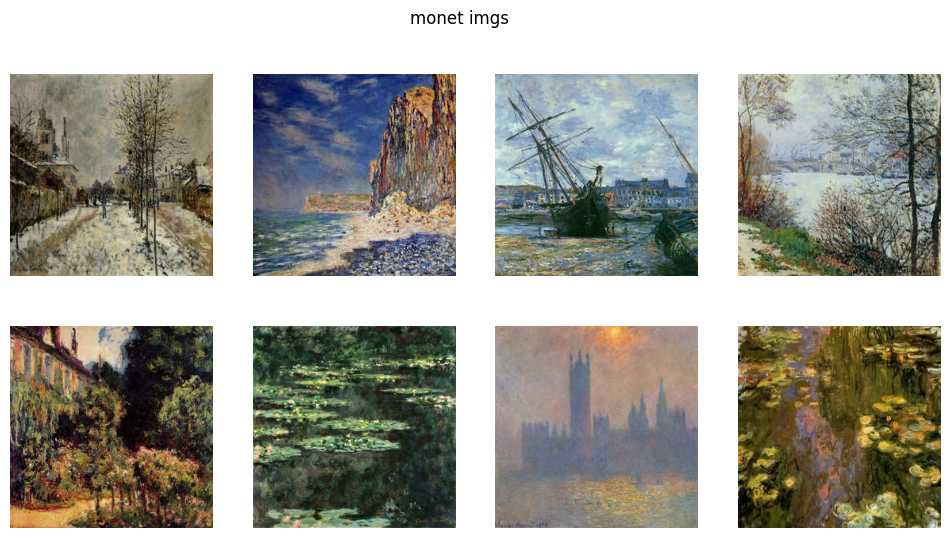

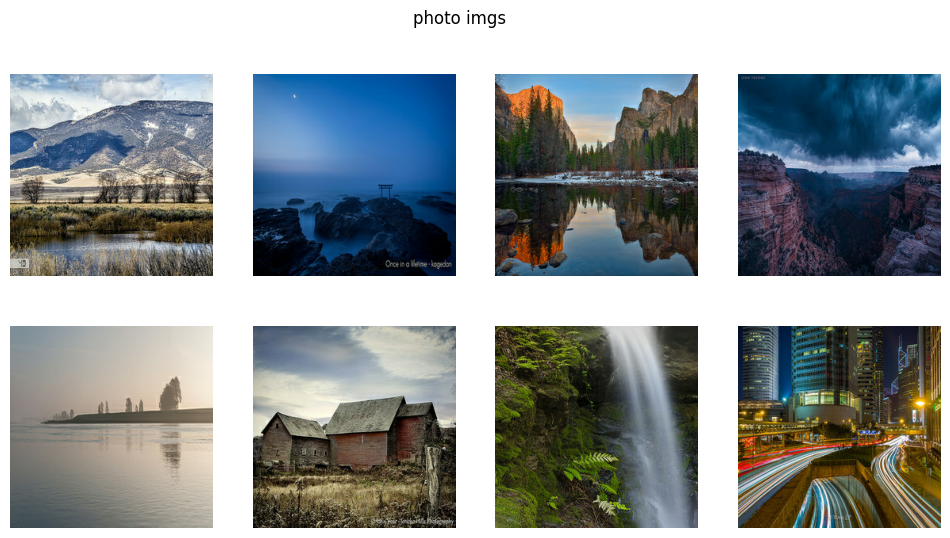

In [5]:
# preview images
def show_batch(dataset, title):
  plt.figure(figsize = (12, 6))
  for images in dataset.take(1):
    for i in range(8):
      ax = plt.subplot(2, 4, i+1)
      plt.imshow(images[i])
      plt.axis('off')
  plt.suptitle(title)
  plt.show()

show_batch(monet_ds, 'monet imgs')
show_batch(photo_ds, 'photo imgs')

I'm no artist and have the creativity of a potato, so bear with me in my lack of descriptive words. The colours of the Monet paintings look 'soft' to me, and the colours of the photos look 'strong'. I'll have a look at the intensity and colour distribution of the pixels next to see if there is a noticeable difference.

In [6]:
# list datasets to explore
datasets = [monet_ds, photo_ds]
dataset_names = ['monet', 'photo']

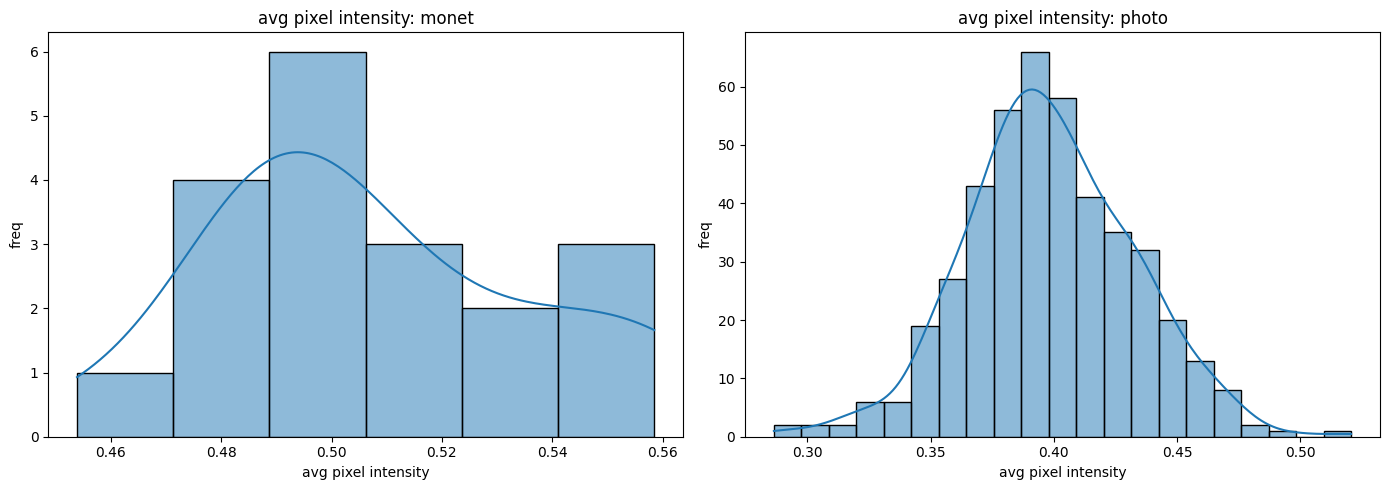

In [7]:
# avg pixle density

# grid layout
fig, axes = plt.subplots(1, 2, figsize=(14, 5)) 

# iterate throough list for mean density
for idx, (dataset, name) in enumerate(zip(datasets, dataset_names)):
    means = []
    for img in dataset.take(1000):
        means.append(tf.reduce_mean(img).numpy())

    sns.histplot(means, 
                 ax = axes[idx], 
                 kde = True)
    axes[idx].set_title(f'avg pixel intensity: {name}')
    axes[idx].set_xlabel('avg pixel intensity')
    axes[idx].set_ylabel('freq')

plt.tight_layout()
plt.show()

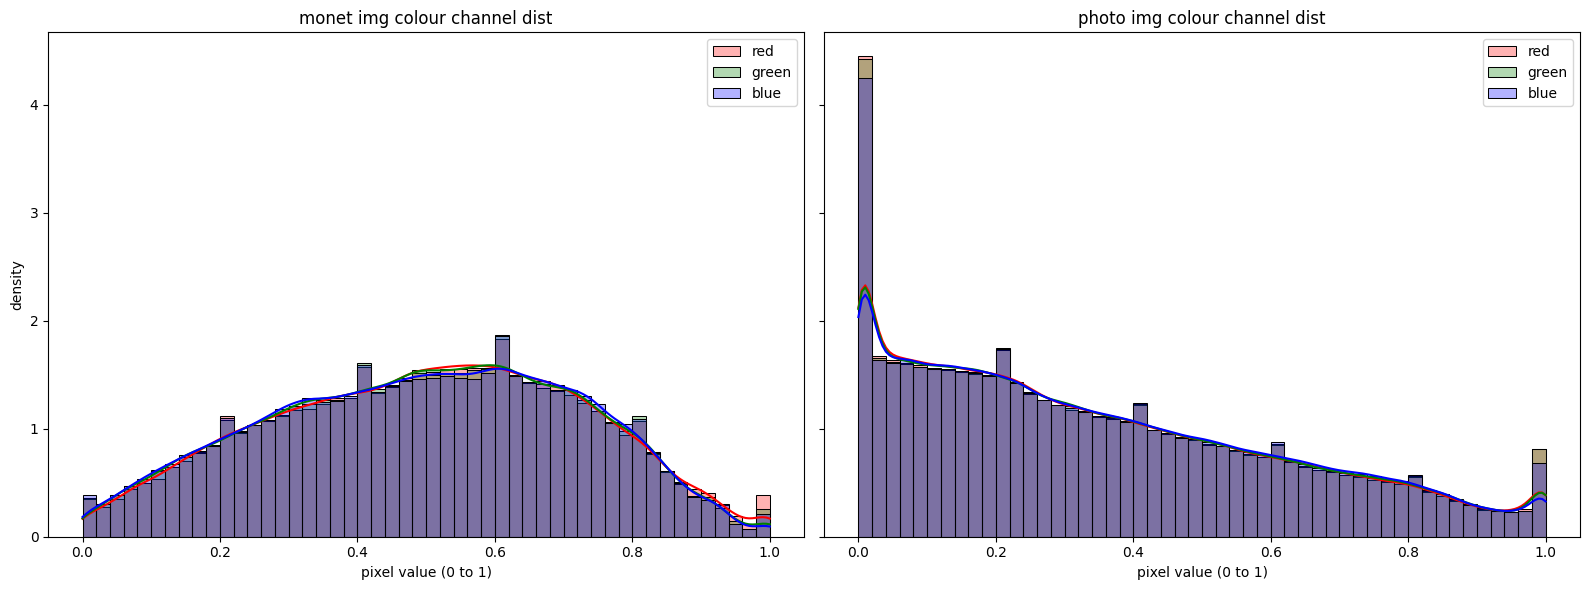

In [8]:
# colour channel dist

# grid layout
fig, axes = plt.subplots(1, 
                         2, 
                         figsize = (16, 6), 
                         sharey = True)

# iterate through list for colour dist
for idx, (dataset, name) in enumerate(zip(datasets, dataset_names)):
    r_vals, g_vals, b_vals = [], [], []

    # colour channel vals
    for img in dataset.take(100):
        img_np = img.numpy()
        r_vals.extend(img_np[:, :, 0].flatten())
        g_vals.extend(img_np[:, :, 1].flatten())
        b_vals.extend(img_np[:, :, 2].flatten())

    # histograms axis
    sns.histplot(r_vals, 
                 color = 'red', 
                 label = 'red', 
                 bins = 50, 
                 stat = 'density', 
                 kde = True, 
                 alpha = 0.3, 
                 ax = axes[idx])
    sns.histplot(g_vals, 
                 color = 'green', 
                 label = 'green', 
                 bins = 50, 
                 stat = 'density', 
                 kde = True, 
                 alpha = 0.3, 
                 ax = axes[idx])
    sns.histplot(b_vals, 
                 color = 'blue', 
                 label = 'blue', 
                 bins = 50, 
                 stat = 'density', 
                 kde = True, 
                 alpha = 0.3, 
                 ax = axes[idx])

    
    axes[idx].set_title(f'{name} img colour channel dist')
    axes[idx].set_xlabel('pixel value (0 to 1)')
    axes[idx].set_ylabel('density')
    axes[idx].legend()

plt.tight_layout()
plt.show()

The difference in the colour distribution between the Monet paintings and the photos is interesting. Pixel values where all of red, green, and blue are 0.0 means that the pixel is pure black. Where the pixel value is 1.0 for all of red, green, and blue, the pixel will be white. The above plots indicate that the photos contain more of both black and white pixels than the Monet paintings, and 

*** Monet Images: Normal-like Bell Curve (without tails)
A bell-shaped distribution centered around the middle of the range (~0.5) suggests:

Most pixels are moderately colored, not extremely dark (0.0) or light (1.0).

There is an absence of pure black or white (i.e., clipped shadows/highlights are rare).

The colors are balanced and soft, with little harsh contrast.

This makes sense for Monet’s impressionist style:

He used pastel tones and blended brushwork, avoiding high contrast.

Large smooth transitions of color with few pure blacks or whites.

✅ Conclusion: Monet images are evenly lit and soft, with rich midtones and low contrast.

📷 Photo Images: Linearly Declining Curve + Spikes at 0.0 and 1.0
A linear downward slope means:

There are more dark pixels than light pixels.

But still a wide spread of brightness across the whole range.

A spike at 0.0:

Indicates a large number of pure black or near-black pixels — possibly from shadows, edges, dark backgrounds.

A smaller spike at 1.0:

Shows the presence of very bright areas — like sky, highlights, reflections.

This is characteristic of natural photos:

Contain strong lighting contrasts.

Have clipped shadows/highlights depending on exposure.

Show higher dynamic range compared to artwork.

✅ Conclusion: Photos are more varied and "raw", with more extreme pixel values due to shadows and lighting.***

## References
1. https://www.masterclass.com/articles/monet-paintings-guide